In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import prettytable as pt
import pandas as pd
import numpy as np

import itertools
import os
import time

In [2]:
#GPU FOR TRAINGING
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Avaliable{}:".format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

editor = "簡名駿"
print("Last edit:{}".format(editor))
print("Time:{}".format(time.ctime(time.time())))

#func for ploting multilabel classification is not finished yet

GPUs Avaliable[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]:
Last edit:簡名駿
Time:Mon Oct 17 20:44:01 2022


In [3]:
#Variables and Constant
DATA = "MLO"
BATCH_SIZE = 32
IMG_SIZE = (224,224)
DATA_CLASS = ['Benign','Malignant']

model_name = "MobileNet"
learning_rate = 1e-5
epochs = 10
show_detail = True

f_columns = ["Date","Model","Batch_size","epochs","Learning_rate","Training_Report","Confusion_Metrix"]
columns = ["Date","Model","Batch_size","epochs","Learning_rate"]
# csv_path = "D:\\111project\\For_Jupyter\\data\\history_report.csv"
csv_path = "D:\\GitHub\\041-111project\\data\\history_report_jc.csv"

In [4]:
#define some functions

def join_path(root:str , *params)-> str:
    # give root and folders / files will return a path in str
    temp = root
    for p in params:
        temp = os.path.join(temp,p)
    return temp

def plot_confusion_metrix(cm, classes
                          ,normalize = False
                          ,title='Confusion matrix'
                          ,cmap=plt.cm.Blues):
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontsize=12)
    plt.yticks(tick_marks,classes,fontsize=12)
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:,np/newaxis]
        # print("Normalized confusion matrix")
    else :
        # print("Confusion matrix")
        pass
    # print(cm)
    
    thresh = cm.max() / 2.
    for i , j in itertools.product(range(cm.shape[0]),range(cm.shape[1])): 
        plt.text(j,i,cm[i,j],
                ha = "center",
                fontsize = 15,
                color = "orange" if cm[i,j]> thresh else "purple")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def plot_multi_label_confusion_metrix(cm,classes,cmap=plt.cm.Blues) -> None:
    #give the whole ConfusionMetrix and classes and it will plot it out
    fig,ax = plt.subplots(2,int(len(cm)/2))
    count = 0
    for a,b in itertools.product(range(2),range(int(len(cm)/2))):


        thresh = cm[count].max() / 2.
        temp_cm = cm[count]
        class_ = classes[count]

        # plt.figure(figsize=(6,6))
        ax[a][b].imshow(temp_cm,interpolation='nearest',cmap=plt.cm.Blues)
        ax[a][b].set_title(class_)

        if(a == 0 and b==0):
            ax[a][b].set_yticks(np.arange(2),["TrueNegative , FalsePositive","FalseNegative , TruePositive "])
        else:
            ax[a][b].set_yticks([])

        ax[a][b].set_xticks([])
        for i,j in itertools.product(range(len(temp_cm[:][0])),range(len(temp_cm[0][:]))):
                ax[a][b].text(j,i,temp_cm[i][j],
                        ha = "center",
                        color = "orange" if temp_cm[i,j]> thresh else "purple")
        count += 1

def plot_acc_loss(acc,val_acc,loss,val_loss):
    #give values from fit history and it will plot out a graph
    plt.figure(figsize=(8,8))

    plt.subplot(2,1,1)
    plt.plot(acc,label="Trainging Accuracy")
    plt.plot(val_acc,label="Validation Accuracy")
    plt.legend(loc="upper left")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1])
    plt.title("Training and Validation Accuracy")

    plt.subplot(2,1,2)
    plt.plot(loss,label="Trainging Loss")
    plt.plot(val_loss,label="Validation Loss")
    plt.legend(loc="upper right")
    plt.ylabel("Cross Entropy")
    # plt.ylim([0,1.0]) #too high so let's not use this now
    plt.title("Trainging and Validation Loss")
    plt.xlabel("epoch")
    plt.show()

def plot_imgs(lots_imgs,lots_labels):
    # give imgs and lables,it will plot it out
    imgs = lots_imgs[:9]
    labels = lots_labels[:9]
    
    plt.figure(figsize=(15,15))
    for i in range(len(imgs)):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i])
        plt.title(labels[i])
        plt.axis("off")

def convert_cm_to_container(cm):
    #give it a Multilabel Confusion Metrix and it will store it in a str, ez for storing in csv
    cm_container = str()
    if len(cm)==2:
        for i ,j in itertools.product(range(len(cm)),range(2)):
            cm_container += "{}_".format(cm[i,j])
    else:
        for i,j,k in itertools.product(range(len(cm)),range(2),range(2)):
            cm_container += "{}_".format(cm[i,j,k])
    return cm_container

def convert_container_to_cm(cm_container):
    #give it the str generate from function above,will return what it suppose to look like originally
    temp = cm_container.split(sep="_")
    size = int((len(temp)-1)/4)
    # print(size)
    if size == 4 or size == 6:
        c_cm = np.empty((size,2,2))
        count = -1
        for i,j,k in itertools.product(range(size),range(2),range(2)):
            count += 1
            # print(count)
            c_cm[i,j,k] = temp[count]
    elif size == 1:
        c_cm = np.empty((2,2))
        count = -1
        for i,j in itertools.product(range(2),range(2)):
            count += 1
            # print(count)
            c_cm[i,j] = temp[count]
    return c_cm

def convert_list_to_str(list_:list) -> str:
    temp = str()
    for item in list_:
        temp += "{}_".format(item)
    return temp

def convert_str_to_list(str_:str) -> list:
    list_ = list()
    str_ = str_.split(sep='_')
    for item in str_[:-1]:
        list_.append(float(item))
    return list_

def show_report(*nums, show_plot:bool=False):
    #give nums to choose which data to show,CAN give multiplay nums at once
    #if want to print out all history better use for loop with it
    #show_plot will control whether to plot ConfusionMetrix or not
    temp = list()
    history_report = pd.read_csv(csv_path)

    table = pt.PrettyTable()
    table.set_style(pt.DOUBLE_BORDER)
    table.hrules=pt.ALL
    temp.append('index')
    for num in nums:
        temp.append(num)
    table.field_names = temp

    for column in ["Date","Model","Batch_size","epochs","Learning_rate","Training_Report"]:
        temp = []
        temp.append(column)
        for num in nums:
            temp.append(history_report.iloc[num][column])
        table.add_row(temp)
    print(table)

    if show_plot == True:
        for num in nums:
            current_cm = convert_container_to_cm(history_report.iloc[num]['Confusion_Metrix'])
            # print(current_cm)
            if len(current_cm)==6:
                plot_multi_label_confusion_metrix(cm=current_cm,classes=['Benign', 'CC', 'Calc', 'MLO', 'Mass', 'Melignant'])
            elif len(current_cm)==4:
                plot_multi_label_confusion_metrix(cm=current_cm,classes=['Benign', 'Calc', 'Mass', 'Melignant'])
            elif len(current_cm)==2:
                plot_confusion_metrix(cm=current_cm,classes=['Benign','Malignant'])
                
            current_row = history_report.iloc[num]
            if current_row.isnull()['acc']==True:
                print('index:{} have no acuracy data for plotting accuracy.'.format(num))
                continue
            print("index:{}".format(num))
            acc = convert_str_to_list(current_row['acc'])
            val_acc = convert_str_to_list(current_row['val_acc'])
            loss = convert_str_to_list(current_row['loss'])
            val_loss = convert_str_to_list(current_row['val_loss'])
            # print(acc,'\n',val_acc,'\n',loss,'\n',val_loss)
            plot_acc_loss(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss)
                
            

In [44]:
#import CBIS-DDSM Cropped image data
cc_path = "D:\\GitHub\\041-111project\\data\\Binary_\\CC"
mlo_path = "D:\\GitHub\\041-111project\\data\\Binary_\\MLO"

if DATA == "CC":
    data_path = cc_path
elif DATA == "MLO":
    data_path = mlo_path

train_path = os.path.join(data_path,"train")
valid_path = os.path.join(data_path,"valid")

train_dataset = ImageDataGenerator().flow_from_directory(directory=train_path,target_size=IMG_SIZE,color_mode="rgb", \
                                                    classes=DATA_CLASS,batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = ImageDataGenerator().flow_from_directory(directory=valid_path,target_size=IMG_SIZE,color_mode="rgb", \
                                                    classes=DATA_CLASS,batch_size=BATCH_SIZE, shuffle=True)

Found 1482 images belonging to 2 classes.
Found 369 images belonging to 2 classes.


In [7]:
# test if data import correctly

# imgs , labels = next(train_dataset)
# imgs = imgs/255.
# plot_imgs(imgs,labels)

# imgs_1,labels_1 = next(valid_dataset)
# imgs_1 = imgs_1/255.
# plot_imgs(imgs_1,labels_1)

In [9]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
],name="Data_augmentation")

#Rescale Pixel Values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#MobileNet itself
base_model = tf.keras.applications.MobileNetV2(input_shape = (IMG_SIZE[0],IMG_SIZE[1],3),
                                                include_top=False,
                                                  weights="imagenet")
base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()

prediction_layer = tf.keras.layers.Dense(len(DATA_CLASS),activation="softmax")


# # Assemble all together
inputs = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = flatten_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

if show_detail == True:
    print("MobileNet Model Created.")
    model.summary()

MobileNet Model Created.


In [12]:
# # Show Data Augmentation
# imgs , _ = next(train_dataset)
# imgs = data_augmentation(imgs)
# imgs = imgs/255.
# plot_imgs(imgs,_)

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate),loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [19]:
loss0,accuracy0 = model.evaluate(valid_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 3s 224ms/step - loss: 0.9638 - accuracy: 0.5664
initial loss: 0.96
initial accuracy: 0.57


In [20]:
history = model.fit(x=train_dataset, epochs=epochs, validation_data=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

Epoch 1/10
47/47 [==============================] - 10s 139ms/step - loss: 0.8078 - accuracy: 0.5580 - val_loss: 0.7515 - val_accuracy: 0.5854
Epoch 2/10
47/47 [==============================] - 7s 138ms/step - loss: 0.7575 - accuracy: 0.5904 - val_loss: 0.7385 - val_accuracy: 0.5962
Epoch 3/10
47/47 [==============================] - 7s 139ms/step - loss: 0.7170 - accuracy: 0.6269 - val_loss: 0.7206 - val_accuracy: 0.5908
Epoch 4/10
47/47 [==============================] - 6s 134ms/step - loss: 0.7216 - accuracy: 0.6120 - val_loss: 0.7196 - val_accuracy: 0.6070
Epoch 5/10
47/47 [==============================] - 7s 142ms/step - loss: 0.7079 - accuracy: 0.6289 - val_loss: 0.7064 - val_accuracy: 0.6152
Epoch 6/10
47/47 [==============================] - 7s 151ms/step - loss: 0.7004 - accuracy: 0.6370 - val_loss: 0.7018 - val_accuracy: 0.6125
Epoch 7/10
47/47 [==============================] - 6s 135ms/step - loss: 0.6968 - accuracy: 0.6343 - val_loss: 0.7013 - val_accuracy: 0.6233
Epoch

In [84]:
predictions = model.predict(valid_dataset)

12/12 [==============================] - 1s 106ms/step


In [85]:
y_pred=np.argmax(predictions,axis=-1)
cm = confusion_matrix(y_true=valid_dataset.classes,y_pred=np.argmax(predictions,axis=-1))
cm_container = convert_cm_to_container(cm)
report = classification_report(y_true=valid_dataset.classes,y_pred=y_pred,target_names=DATA_CLASS)

In [161]:
history_report = pd.read_csv(csv_path)
history_report.loc[len(history_report)]=(time.ctime(time.time()),
                                            model_name,
                                            BATCH_SIZE,
                                            epochs,
                                            learning_rate,
                                            report,
                                            cm_container,
                                            convert_list_to_str(acc),
                                            convert_list_to_str(val_acc),
                                            convert_list_to_str(loss),
                                            convert_list_to_str(val_loss))
history_report.to_csv(csv_path,index=False)

In [252]:
# history_report = pd.read_csv(csv_path)
# columns = ['acc','val_acc','loss','val_loss']
# for c in columns:
#     temp = []
#     for i in range(len(history_report)):
#         temp.append("NaN")
#     history_report[c]=temp
# history_report = history_report.drop(['Unnamed:0'],axis='columns')
# history_report.to_csv(csv_path,index=False)

In [185]:
history_report.to_csv(csv_path,index=False)

╔═════════════════╦═══════════════════════════════════════════════════════╗
║      index      ║                           -1                          ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║       Date      ║                Mon Oct 10 23:21:41 2022               ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║      Model      ║                       MobileNet                       ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║    Batch_size   ║                           32                          ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║      epochs     ║                           10                          ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║  Learning_rate  ║                         1e-05                         ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║ Training_R

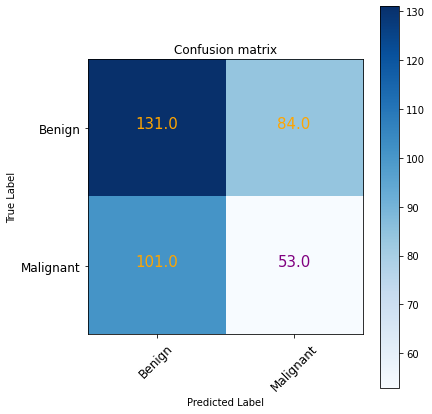

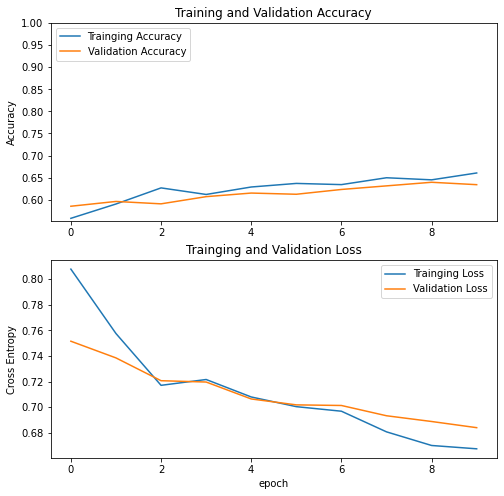

In [6]:
show_report(-1,show_plot=True)